# SQL資料更新

In [2]:
import pyodbc
import pandas as pd
import numpy as np
import warnings
from tqdm import tqdm
warnings.filterwarnings("ignore")
DB_Host = "192.168.1.16"
DB_Name = "X01"
DB_User = "cm23357868"#以我的帳號為例，請填入您個人帳號
DB_Password = "86875332"#以我的密碼為例，請填入您個人密碼

print("Connecting to database using pyodbc...")

db = pyodbc.connect('DRIVER={ODBC Driver 13 for SQL Server}; SERVER=' + DB_Host + '; DATABASE=' + DB_Name + '; UID=' + DB_User + '; PWD=' + DB_Password)

print("Succesfully Connected to database using pyodbc!")

cursor = db.cursor()
#假設我有個列表(tuple也可以)裡面有股票代號，示範只導入前十項

s_code_df = pd.read_excel("C:\\Users\\larryx30\\Desktop\\ALLSTOCK.xlsx")
stock_ls = list(s_code_df.loc[0:,'NUM'])
data_ls = []
data_frame = pd.DataFrame()
for stock_code in tqdm(stock_ls):
    query1 = """SELECT  [日期]
      ,[股票代號]
      ,[股票名稱]
      ,[資使用率]
      ,[融資維持率(%%)]
      FROM [X01].[dbo].[日融資券排行] WITH(NOLOCK) where 股票代號 = '%s' And 日期 >= 20070101 order by 日期 """ %stock_code
    query2 = """SELECT [日期]
      ,[股票代號]
      ,[股票名稱]
      ,[開盤價]
      ,[最高價]
      ,[最低價]
      ,[收盤價]
      ,[成交金額(千)]
      FROM [X01].[dbo].[日收盤表排行] WITH(NOLOCK) where 股票代號 = '%s' And 日期 >= 20070101 order by 日期 """ %stock_code
    query3 = """SELECT [日期]
      ,[股票代號]
      ,[股票名稱]
      ,[還原收盤價]
      FROM [X01].[dbo].[日報酬率比較表] WITH(NOLOCK) where 股票代號 = '%s' And 日期 >= 20070101 order by 日期 """  %stock_code
    df_Financing = pd.read_sql(query1, db)#.dropna()
    df_price = pd.read_sql(query2, db)
    df_res_price = pd.read_sql(query3, db)
    
    df_from_sql = df_price.merge(df_Financing, on= ['日期', '股票代號', '股票名稱']).fillna(0)
    df_from_sql = df_from_sql.merge(df_res_price, on= ['日期', '股票代號', '股票名稱']).fillna(0)
    df_from_sql['日期'] = pd.to_datetime(df_from_sql['日期'],format = "%Y%m%d").fillna(0)
    df_from_sql = df_from_sql.set_index('日期')
    data_ls.append(df_from_sql)
    data_frame = pd.concat([data_frame,df_from_sql],axis = 0)
    


Connecting to database using pyodbc...
Succesfully Connected to database using pyodbc!


100%|██████████| 1776/1776 [1:02:00<00:00,  2.09s/it] 


# 整理樞紐1

In [3]:
feature_ls = data_frame.columns[3:]
data_frame = data_frame.reset_index(drop = False)
data_pivots_ls = []
for feature in tqdm(feature_ls):
    data_pivot = data_frame.pivot('日期','股票代號',feature)
    data_pivots_ls.append(data_pivot)
data_dict = {str(stock_ls[i]):data_ls[i] for i in range(len(stock_ls))}
    

100%|██████████| 7/7 [00:13<00:00,  1.95s/it]


# 整理樞紐2及字典合併

In [4]:
pivot_dict = {str(feature_ls[i]):data_pivots_ls[i] for i in range(len(feature_ls))}
data_dict.update(pivot_dict)

# 回測樣本代號

In [5]:
response1 = pd.read_excel(r"C:\Users\larryx30\Desktop\\ALLSTOCK.xlsx")
response1.index = response1.index+1
AS = response1['NUM']
response2 = pd.read_excel(r"C:\Users\larryx30\Desktop\\TCRINEW.xlsx")
response2.index = response2.index+1
SKTCRI = response2['NUM']
response3 = pd.read_excel(r"C:\Users\larryx30\Desktop\\STOCKFUTURE.xlsx")
response3.index = response3.index+1
SF = response3['NUM']
DDW = {}
for j in tqdm(AS):
    DDW[str(j)] = data_dict[str(j)].resample('W-FRI').agg({'開盤價':'first', '最高價':'max', '最低價':'min', '收盤價':'last','成交金額(千)':'sum','資使用率':'last','融資維持率(%)':'last', '還原收盤價':'last'})
for fi in tqdm(AS):
    DDW[str(fi)] = DDW[str(fi)].fillna(method = 'pad' ,axis = 0)

100%|██████████| 1776/1776 [00:00<00:00, 13675.09it/s]


# 計算大盤夏普

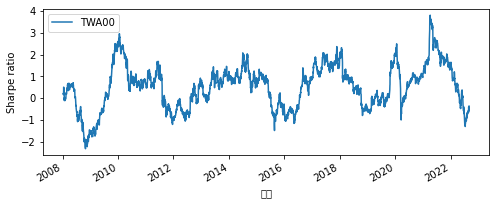

In [6]:
import matplotlib.pyplot as plt
import mplfinance as mpf
import seaborn as sns
shar2 = pd.DataFrame()

change2 = data_dict["TWA00"]["還原收盤價"].pct_change()
sigma2 = change2.std()
data_dict["TWA00"]['rolling_ret'] = change2.rolling(252).mean()
data_dict["TWA00"]['rolling_std'] = change2.rolling(252).std()
data_dict["TWA00"]['sharpe'] = (data_dict["TWA00"]['rolling_ret'] / data_dict["TWA00"]['rolling_std']) * (252 ** 0.5)

APT2 = data_dict["TWA00"]["sharpe"]
APT2.name = 'TWA00'
DDW['TWA00']["sharpe"] = data_dict['TWA00']['sharpe'].groupby(pd.Grouper(freq='1W')).tail(1)
if len(shar2) == 0:
    shar2 = APT2
else:
    shar2 = pd.merge(shar2,APT2,left_on = shar2.index,right_on = APT2.index,how = 'outer')
    shar2.set_index('key_0',inplace = True)

plt.figure(figsize=(8,3))
plt.xlabel("time")
plt.ylabel("Sharpe ratio")
shar2.plot(label = "TWA00")
plt.legend()

# 計算全股票夏普

100%|██████████| 1776/1776 [00:39<00:00, 44.99it/s]


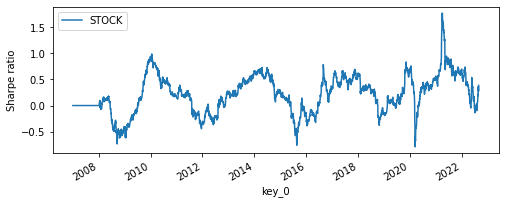

In [7]:
#Sharpe
shar = pd.DataFrame()

for i in tqdm(AS):
    change = data_dict[str(i)]["還原收盤價"].pct_change()
    sigma = change.std()
    data_dict[str(i)]['rolling_ret'] = change.rolling(252).mean()
    data_dict[str(i)]['rolling_std'] = change.rolling(252).std()
    data_dict[str(i)]['sharpe'] = (data_dict[str(i)]['rolling_ret'] / data_dict[str(i)]['rolling_std']) * (252 ** 0.5)

    APT = data_dict[str(i)]["sharpe"]
    APT.name = i

    if len(shar) == 0:
        shar = APT
    else:
        shar = pd.merge(shar,APT,left_on = shar.index,right_on = APT.index,how = 'outer')
        shar.set_index('key_0',inplace = True)

plt.figure(figsize=(8,3))
plt.xlabel("time")
plt.ylabel("Sharpe ratio")
wholesharpe = shar.sort_index().sum(axis = 1)/len(shar.columns)
wholesharpe.plot(label = "STOCK")
plt.legend()

# 母關鍵點策略

100%|██████████| 1100/1100 [02:21<00:00,  7.80it/s]


Text(0, 0.5, 'Profit')

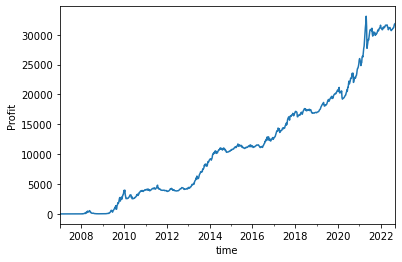

In [8]:
import talib
ERROR = []
trr = pd.DataFrame()
pz = pd.DataFrame()

for x in tqdm(SKTCRI):
    
    DDW[str(x)]['MAX52'] = DDW[str(x)]["還原收盤價"].rolling(52).max()
    DDW[str(x)]["MAX52S"] = DDW[str(x)]["MAX52"].shift(1)
    DDW[str(x)]["4MA"] = talib.MA(DDW[str(x)]["還原收盤價"].dropna(), timeperiod=5, matype=0)
    DDW[str(x)]["4MAS"] = DDW[str(x)]["4MA"].shift(1)
    DDW[str(x)]["DR"] = ((DDW[str(x)]["還原收盤價"] - DDW[str(x)]["還原收盤價"].shift(1))/DDW[str(x)]["還原收盤價"].shift(1))*100
    KPBS = 0
    KPBUY =[]
    for z in range(len(DDW[str(x)])):

        if DDW[str(x)]["還原收盤價"].iloc[z]  > DDW[str(x)]["MAX52S"].iloc[z] and  DDW[str(x)]["成交金額(千)"].iloc[z] > 50000 and  DDW[str(x)]["資使用率"].iloc[z] < 15  :
        
            KPBS = 1

        elif DDW[str(x)]["4MA"].iloc[z] < DDW[str(x)]["4MAS"].iloc[z] and DDW[str(x)]['收盤價'].iloc[z] < DDW[str(x)]['最低價'].shift(1).iloc[z] :
            KPBS = 0
            #buy.append("0")
        KPBUY.append(KPBS)
    DDW[str(x)]["KPBUY"] = KPBUY
    DDW[str(x)]["KPBUYS"] = DDW[str(x)]["KPBUY"].shift(1)
    pzb = DDW[str(x)]["KPBUYS"]  
    pzb.name = str(x)
    pzbs = DDW[str(x)]["KPBUY"]
    pzbs.name = str(x)
    DDW[str(x)]["KPRR"] = DDW[str(x)]["DR"] * DDW[str(x)]["KPBUYS"].dropna().astype(int)
    PT = DDW[str(x)]["KPRR"]
    PT.name = str(x)
    if len(trr) == 0:
        trr = PT
    else:
        trr = pd.merge(trr,PT,left_on = trr.index,right_on = PT.index,how = 'outer')
        trr.set_index('key_0',inplace = True)
    if len(pz) == 0:
        pz = pzbs
    else:
        pz = pd.merge(pz,pzbs,left_on = pz.index,right_on = pzbs.index,how = 'outer')
        pz.set_index('key_0',inplace = True)

trrb =trr.sort_index().sum(axis = 1).cumsum().plot()

plt.xlabel("time")
plt.ylabel("Profit")


# 整理多單買賣訊01值

85.45354523227384
0.0
462.0


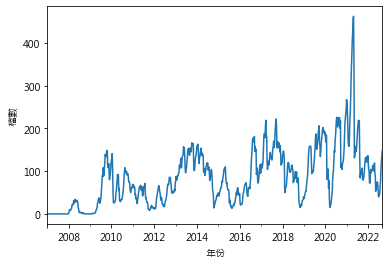

In [9]:
pz1 = pz.sort_index()
f = lambda x :float(x)
pz2 = pz1.applymap(f)
pz3 = pz2.sum(axis=1)
pz4 = pz3.groupby(pd.Grouper(freq='1W')).tail(1)
plt.rcParams['font.family'] = ['Microsoft JhengHei'] # 中文標籤
plt.rcParams['axes.unicode_minus'] = False # 負號
print(pz4.mean())
print(pz4.min())
print(pz4.max())
pz4.plot()
plt.xlabel("年份")
plt.ylabel("檔數")
plt.savefig('多方部位變化表.png')


# 關鍵點當週買進部位

In [10]:
當週日期 = '2022-08-26'
前週日期 = '2022-08-19'

關鍵點持有部位 = pz2.loc[當週日期][(pz2.loc[當週日期]==1)]
關鍵點買進 = pz2.loc[當週日期][(pz2.loc[當週日期]==1) & (pz2.loc[前週日期]==0)]
關鍵點賣出 = pz2.loc[當週日期][(pz2.loc[當週日期]==0) & (pz2.loc[前週日期]==1)]
print("關鍵點買進標的")
print(關鍵點買進)
print("關鍵點買進檔數" , len(關鍵點買進))
print("關鍵點持有部位數目" , len(關鍵點持有部位))
print("關鍵點賣出部位")
print(關鍵點賣出)
print("關鍵點賣出檔數" , len(關鍵點賣出))

關鍵點買進標的
1342    1.0
1752    1.0
1813    1.0
4105    1.0
4550    1.0
4766    1.0
5225    1.0
5489    1.0
6221    1.0
6227    1.0
6768    1.0
8072    1.0
8374    1.0
Name: 2022-08-26 00:00:00, dtype: float64
關鍵點買進檔數 13
關鍵點持有部位數目 137
關鍵點賣出部位
Series([], Name: 2022-08-26 00:00:00, dtype: float64)
關鍵點賣出檔數 0


# 關鍵點歷年損益

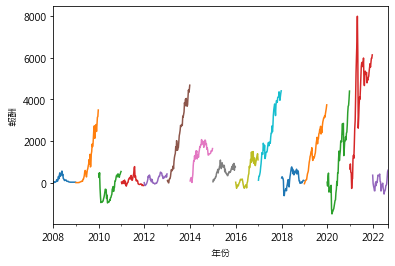

In [11]:
yl = ['2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019','2020','2021','2022']
for h in yl :
    trrt = trr.groupby(pd.Grouper(freq='1W')).sum().sum(axis=1)[str(h)].cumsum()
    trrtfig = trrt.plot()
trrtfig = plt.gcf()

plt.xlabel("年份")
plt.ylabel("報酬")
trrtfig.savefig('主模型歷年損益.png')

# 放空補丁策略

100%|██████████| 1100/1100 [03:14<00:00,  5.65it/s]


<AxesSubplot:xlabel='key_0'>

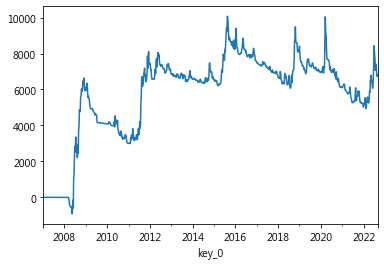

In [13]:
import talib
ERROR = []
trrs = pd.DataFrame()
pzs = pd.DataFrame()

for x in tqdm(SKTCRI):
    
    DDW[str(x)]['LOW5'] = DDW[str(x)]["最低價"].rolling(2).min()
    DDW[str(x)]['SMAX3'] = DDW[str(x)]["最高價"].rolling(2).max()
    DDW[str(x)]["LOW5S"] = DDW[str(x)]["LOW5"].shift(1)
    DDW[str(x)]["4SELLMA"] = talib.MA(DDW[str(x)]["還原收盤價"].dropna(), timeperiod=4, matype=0)
    DDW[str(x)]["4SELLMAS"] = DDW[str(x)]["4SELLMA"].shift(1)
    DDW[str(x)]["30SELLMA"] = talib.MA(DDW[str(x)]["還原收盤價"].dropna(), timeperiod=30, matype=0)
    DDW[str(x)]["60SELLMA"] = talib.MA(DDW[str(x)]["還原收盤價"].dropna(), timeperiod=60, matype=0)
    DDW[str(x)]["DR"] = ((DDW[str(x)]["還原收盤價"] - DDW[str(x)]["還原收盤價"].shift(1))/DDW[str(x)]["還原收盤價"].shift(1))*100
    DDW['TWA00']['4SELLHMA'] = talib.MA(DDW['TWA00']["收盤價"].dropna(), timeperiod=2, matype=0)
    DDW['TWA00']['20SELLHMA'] = talib.MA(DDW['TWA00']["收盤價"].dropna(), timeperiod=20, matype=0)
    DDW[str(x)]['大盤夏普']= DDW['TWA00']['sharpe'].fillna(method = 'pad',axis =0)
    BSS = 0
    SELL =[]
    for z in range(len(DDW[str(x)])):

        if DDW[str(x)]['成交金額(千)'].iloc[z] > 100000 and DDW[str(x)]["30SELLMA"].iloc[z] < DDW[str(x)]["30SELLMA"].shift(1).iloc[z] \
        and DDW[str(x)]["還原收盤價"].iloc[z]  <  DDW[str(x)]["60SELLMA"].iloc[z]  \
        and DDW[str(x)]['收盤價'].iloc[z] < DDW[str(x)]['LOW5S'].iloc[z] and DDW[str(x)]['融資維持率(%)'].iloc[z] > 135 and DDW[str(x)]['資使用率'].iloc[z] > 3 \
         :
            BSS = -1

        elif DDW[str(x)]['收盤價'].iloc[z] > DDW[str(x)]['最高價'].shift(4).iloc[z] or DDW[str(x)]['融資維持率(%)'].iloc[z] < 135 :
            BSS = 0
        
        #if  DDW['TWA00']['4SELLHMA'].iloc[z] > DDW['TWA00']['20SELLHMA'].iloc[z]  :
            #BSS = 0
            
        SELL.append(BSS)
    DDW[str(x)]["SELL"] = SELL
    DDW[str(x)]["SELLS"] = DDW[str(x)]["SELL"].shift(1)
    ps = DDW[str(x)]["SELLS"]  
    ps.name = str(x)
    pss = DDW[str(x)]["SELL"]
    pss.name = str(x)
    DDW[str(x)]["SRR"] = DDW[str(x)]["DR"] * DDW[str(x)]["SELLS"].dropna().astype(int)
    PTS = DDW[str(x)]["SRR"]
    PTS.name = str(x)
    if len(trrs) == 0:
        trrs = PTS
    else:
        trrs = pd.merge(trrs,PTS,left_on = trrs.index,right_on = PTS.index,how = 'outer')
        trrs.set_index('key_0',inplace = True)
    if len(pzs) == 0:
        pzs = pss
    else:
        pzs = pd.merge(pzs,pss,left_on = pzs.index,right_on = pss.index,how = 'outer')
        pzs.set_index('key_0',inplace = True)

trrsp = trrs.sort_index().sum(axis = 1).cumsum()
trrsp.plot()

# 整理空單買賣訊01值

-54.50977995110024
-169.0
0.0


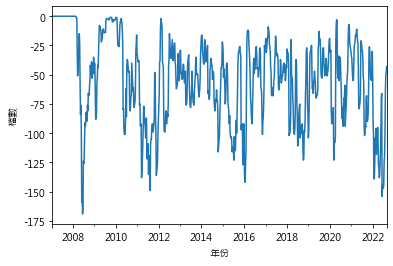

In [14]:
pzs1 = pzs.sort_index()
f1 = lambda x :float(x)
pzs2 = pzs1.applymap(f1)
pzs3 = pzs2.sum(axis=1)
pzs4 = pzs3.groupby(pd.Grouper(freq='1W')).tail(1)
print(pzs4.mean())
print(pzs4.min())
print(pzs4.max())
pzs4.plot()
plt.xlabel("年份")
plt.ylabel("檔數")
plt.savefig('空方部位變化表.png')

# 空單當週放空部位

In [15]:
空單放空部位 = pzs2.loc[當週日期][(pzs2.loc[當週日期]== -1)]
空單放空 = pzs2.loc[當週日期][(pzs2.loc[當週日期]== -1) & (pzs2.loc[前週日期]==0)]
空單回補 = pzs2.loc[當週日期][(pzs2.loc[當週日期]==0) & (pzs2.loc[前週日期]==-1)]
print("空單放空標的")
print(空單放空)
print("空單放空檔數" , len(空單放空))
print("空單持有空單部位數目" , len(空單放空部位))
print("空單回補部位")
print(空單回補)
print("空單回補檔數" , len(空單回補))

空單放空標的
1565   -1.0
2439   -1.0
2603   -1.0
2606   -1.0
2636   -1.0
2637   -1.0
2641   -1.0
3078   -1.0
6108   -1.0
6261   -1.0
Name: 2022-08-26 00:00:00, dtype: float64
空單放空檔數 10
空單持有空單部位數目 48
空單回補部位
1515    0.0
1533    0.0
1701    0.0
2615    0.0
3033    0.0
3035    0.0
3260    0.0
3552    0.0
4128    0.0
4739    0.0
6147    0.0
6525    0.0
Name: 2022-08-26 00:00:00, dtype: float64
空單回補檔數 12


# 空單歷年損益

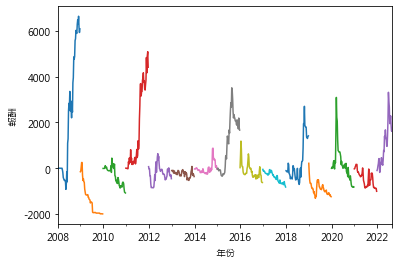

In [16]:

yl = ['2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019','2020','2021','2022']
for h in yl :
    trrts = trrs.groupby(pd.Grouper(freq='1W')).sum().sum(axis=1)[str(h)].cumsum()
    trrtsfig = trrts.plot()
trrtsfig = plt.gcf()

plt.xlabel("年份")
plt.ylabel("報酬")
trrtfig.savefig('空單歷年損益.png')

# 台積電策略

,開盤價,最高價,最低價,收盤價,成交金額(千),資使用率,融資維持率(%),還原收盤價,MAX52,MAX52S,...,MAXNS,MINN2330,MINNS,2330MA,2330SMA,2330LMA,出場價,BUY2330,BUY2330S,2330RR
日期,,,,,,,,,,,,,,,,,,,,,
2022-07-01,496.0,506.0,452.5,453.5,101484303,0.48,141.812302,453.5,665.08,665.08,...,537.08,453.5,486.5,547.5240,557.0140,547.5240,485.0,0,0.0,-0.000000
2022-07-08,443.0,470.5,433.0,467.0,111564512,0.44,149.813095,467.0,665.08,665.08,...,527.14,453.5,453.5,539.3520,547.5240,539.3520,452.5,0,0.0,0.000000
2022-07-15,468.0,494.0,449.5,492.5,87577222,0.45,160.307007,492.5,665.08,665.08,...,501.00,453.5,453.5,534.0880,539.3520,534.0880,433.0,0,0.0,0.000000
2022-07-22,495.5,505.0,486.5,503.0,73948506,0.42,164.319794,503.0,665.08,665.08,...,492.50,453.5,453.5,529.7945,534.0880,529.7945,433.0,0,0.0,0.000000
2022-07-29,500.0,510.0,491.0,509.0,60449457,0.40,166.494400,509.0,665.08,665.08,...,503.00,467.0,453.5,526.7910,529.7945,526.7910,433.0,0,0.0,0.000000
2022-08-05,506.0,516.0,488.5,516.0,79612324,0.38,169.247604,516.0,665.08,665.08,...,509.00,492.5,467.0,523.6980,526.7910,523.6980,433.0,0,0.0,0.000000
2022-08-12,510.0,518.0,499.5,517.0,57766953,0.38,169.583405,517.0,665.08,665.08,...,516.00,503.0,492.5,519.8095,523.6980,519.8095,449.5,0,0.0,0.000000
2022-08-19,520.0,527.0,517.0,519.0,54978043,0.37,169.916199,519.0,665.08,665.08,...,517.00,509.0,503.0,516.4685,519.8095,516.4685,486.5,1,0.0,0.000000
2022-08-26,511.0,515.0,502.0,512.0,42004744,0.37,167.669403,512.0,665.08,665.08,...,519.00,512.0,509.0,513.8715,516.4685,513.8715,488.5,1,1.0,-1.348748


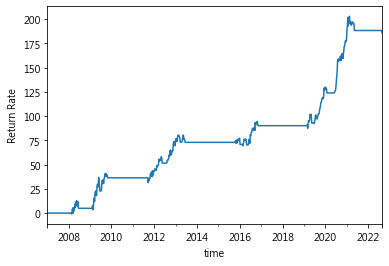

In [17]:
import talib
ERROR = []
trr2330 = pd.DataFrame()
pz2330 = pd.DataFrame()


    
DDW['2330']['MAXN2330'] = DDW['2330']["還原收盤價"].rolling(4).max()
DDW['2330']["MAXNS"] = DDW['2330']["MAXN2330"].shift(1)
DDW['2330']['MINN2330'] = DDW['2330']["還原收盤價"].rolling(4).min()
DDW['2330']["MINNS"] = DDW['2330']["MINN2330"].shift(1)
DDW['2330']["2330MA"] = talib.MA(DDW['2330']["還原收盤價"].dropna(), timeperiod=20, matype=0)
DDW['2330']["2330SMA"] = DDW['2330']["2330MA"].shift(1)
DDW['2330']["2330LMA"] = talib.MA(DDW['2330']["還原收盤價"].dropna(), timeperiod=20, matype=0)
DDW['2330']["DR"] = ((DDW['2330']["還原收盤價"] - DDW['2330']["還原收盤價"].shift(1))/DDW['2330']["還原收盤價"].shift(1))*100
DDW['TWA00']['4SHMA'] = talib.MA(DDW['TWA00']["sharpe"].dropna(), timeperiod=4, matype=0)
DDW['TWA00']['20SHMA'] = talib.MA(DDW['TWA00']["sharpe"].dropna(), timeperiod=20, matype=0)
DDW['2330']['出場價'] = DDW['2330']["最低價"].rolling(4).min().shift(1)
BS2330 = 0
BUY2330 =[]
for z in range(len(DDW['2330'])):

    if  DDW['2330']["還原收盤價"].iloc[z]  >  DDW['2330']["2330MA"].iloc[z] and DDW['2330']['收盤價'].iloc[z] > DDW['2330']['最高價'].rolling(2).max().shift(1).iloc[z] \
    and   DDW['TWA00']['4SHMA'].iloc[z] < 0.3 :
         BS2330 = 1

    elif  DDW['2330']["收盤價"].iloc[z] < DDW['2330']["出場價"].iloc[z]   :
        BS2330 = 0
        
    
        BS2330 = 0
        #buy.append("0")
    BUY2330.append(BS2330)
DDW['2330']["BUY2330"] = BUY2330
DDW['2330']["BUY2330S"] = DDW['2330']["BUY2330"].shift(1)
pz2330 = DDW['2330']["BUY2330S"]  
pz2330.name = '2330'
pzz2330 = DDW['2330']["BUY2330"]
pzz2330.name = '2330'
DDW['2330']["2330RR"] = DDW['2330']["DR"] * DDW['2330']["BUY2330S"].dropna().astype(int)
PTS2330 = DDW['2330']["2330RR"]
PTS2330.name = '2330'
if len(trr2330) == 0:
    trr2330 = PTS2330
else:
    trr2330 = pd.merge(trr2330,PTS2330,left_on = trrs.index,right_on = PTS.index,how = 'outer')
    trr2330.set_index('key_0',inplace = True)

trr2330fig = trr2330.cumsum().plot()
trr2330fig = plt.gcf()
plt.xlabel("time")
plt.ylabel("Return Rate")
trr2330fig.savefig('2330')
DDW['2330'].tail(10)

# 全市場夏普處理與合併

In [18]:
# 日期處理及設定reblance間隔

#設定rebalance頻率及sharpe觀察日數
rebalance = 52

#設定納入股票檔數
count = 10
fee = 2
#主程式
shar = pd.DataFrame()

#計算個股Sharpe ratio
for i in tqdm(DDW.keys()):
    change = DDW[str(i)]["還原收盤價"].pct_change()
    sigma = change.std()
    DDW[str(i)]['rolling_ret'] = change.rolling(rebalance).mean()
    DDW[str(i)]['rolling_std'] = change.rolling(rebalance).std()
    DDW[str(i)]['sharpe105'] = DDW[str(i)]['rolling_ret'] / DDW[str(i)]['rolling_std']
    APT = DDW[str(i)]["sharpe105"]
    APT.name = str(i)

    if len(shar) == 0:
        shar = APT
    else:
        shar = pd.merge(shar,APT,left_on = shar.index,right_on = APT.index,how = 'outer')
        shar.set_index('key_0',inplace = True)
        shar.index.name = '日期'
shar1 = shar.quantile(0.99,axis= 1)
shar2 = pd.DataFrame(shar1.sort_index()).rename(columns = {0.99:'sharp1'})
for key in tqdm(DDW.keys()):
    DDW[key] =  DDW[key].merge(shar2,left_index=True,right_index = True,how='left')
DDW['2330']

100%|██████████| 1776/1776 [00:01<00:00, 1228.08it/s]


,開盤價,最高價,最低價,收盤價,成交金額(千),資使用率,融資維持率(%),還原收盤價,MAX52,MAX52S,...,2330SMA,2330LMA,出場價,BUY2330,BUY2330S,2330RR,rolling_ret,rolling_std,sharpe105,sharp1
日期,,,,,,,,,,,,,,,,,,,,,
2007-01-05,67.8,68.7,66.5,66.9,8206607,0.34,172.881607,37.13,NaN,NaN,...,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN
2007-01-12,66.1,69.5,64.0,69.1,21761444,0.31,175.889297,38.35,NaN,NaN,...,NaN,NaN,NaN,0,0.0,0.000000,NaN,NaN,NaN,NaN
2007-01-19,69.4,71.7,68.8,69.8,20786726,0.28,173.400803,38.74,NaN,NaN,...,NaN,NaN,NaN,0,0.0,0.000000,NaN,NaN,NaN,NaN
2007-01-26,70.0,71.2,67.0,68.0,23118899,0.35,167.302307,37.74,NaN,NaN,...,NaN,NaN,NaN,0,0.0,-0.000000,NaN,NaN,NaN,NaN
2007-02-02,68.3,68.8,65.9,67.8,17254673,0.37,166.893600,37.63,NaN,NaN,...,NaN,NaN,64.0,0,0.0,-0.000000,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-05,506.0,516.0,488.5,516.0,79612324,0.38,169.247604,516.00,665.08,665.08,...,526.7910,523.6980,433.0,0,0.0,0.000000,-0.001747,0.031514,-0.055424,0.272883
2022-08-12,510.0,518.0,499.5,517.0,57766953,0.38,169.583405,517.00,665.08,665.08,...,523.6980,519.8095,449.5,0,0.0,0.000000,-0.001384,0.031445,-0.044010,0.292236
2022-08-19,520.0,527.0,517.0,519.0,54978043,0.37,169.916199,519.00,665.08,665.08,...,519.8095,516.4685,486.5,1,0.0,0.000000,-0.000350,0.030693,-0.011390,0.317406


# 去除多欄(資料多_X才處理)

In [ ]:
for key in tqdm(DDW.keys()):
    DDW[key] = DDW[key].drop(columns = ['sharp1_x','sharp1_y'])

# M夏普策略

100%|██████████| 1100/1100 [05:07<00:00,  3.57it/s]


<AxesSubplot:xlabel='key_0'>

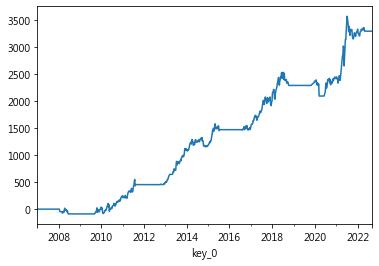

In [20]:
import talib
ERROR = []
trrmsharpe = pd.DataFrame()
pzmsp = pd.DataFrame()
for x in tqdm(SKTCRI):
    
    BQT = 0
    BUYQT =[]
    for z in range(len(DDW[str(x)])):

        if DDW[str(x)]['sharpe105'].iloc[z] > DDW[str(x)]['sharp1'].iloc[z]  and DDW[str(x)]['成交金額(千)'].iloc[z] > 30000 and DDW[str(x)]['sharpe105'].iloc[z] > 0 \
        and DDW[str(x)]['資使用率'].iloc[z] < 30 and DDW[str(x)]['大盤夏普'].iloc[z] > 0.4 :
            BQT = 1

        elif   DDW[str(x)]["收盤價"].iloc[z] < DDW[str(x)]["最低價"].shift(1).rolling(4).min().iloc[z] or DDW[str(x)]['大盤夏普'].iloc[z] < 0:
            BQT = 0
        
        #if  DDW['TWA00']['4SELLHMA'].iloc[z] > DDW['TWA00']['20SELLHMA'].iloc[z]  :
            #BSS = 0
            
        BUYQT.append(BQT)
    DDW[str(x)]["BUYQT"] = BUYQT
    DDW[str(x)]["BUYQTS"] = DDW[str(x)]["BUYQT"].shift(1)
    tqt = DDW[str(x)]["BUYQTS"]  
    tqt.name = str(x)
    pqt = DDW[str(x)]["BUYQT"]
    pqt.name = str(x)
    DDW[str(x)]["QTRR"] = DDW[str(x)]["DR"] * DDW[str(x)]["BUYQTS"].dropna().astype(int)
    PQT = DDW[str(x)]["QTRR"]
    PQT.name = str(x)    
    if len(trrmsharpe) == 0:
        trrmsharpe = PQT
    else:
        trrmsharpe = pd.merge(trrmsharpe,PQT,left_on = trrmsharpe.index,right_on = PQT.index,how = 'outer')
        trrmsharpe.set_index('key_0',inplace = True)
    if len(pzmsp) == 0:
        pzmsp = pqt
    else:
        pzmsp = pd.merge(pzmsp,pqt,left_on = pzmsp.index,right_on = pqt.index,how = 'outer')
        pzmsp.set_index('key_0',inplace = True)

tqt1 = trrmsharpe.sort_index().sum(axis = 1).cumsum()
tqt1.plot()

# 整理夏普買賣訊01值

8.145476772616137
0.0
28.0


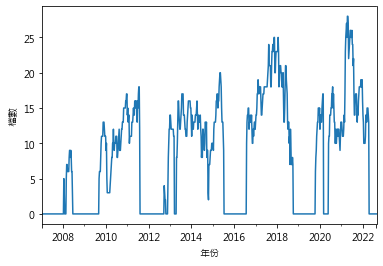

In [22]:
夏普1 = pzmsp.sort_index()
f2 = lambda x :float(x)
夏普2 = 夏普1.applymap(f2)
夏普3 = 夏普2.sum(axis=1)
夏普部位 =夏普3.groupby(pd.Grouper(freq='1W')).tail(1)
print(夏普部位.mean())
print(夏普部位.min())
print(夏普部位.max())
夏普部位.plot()
plt.xlabel("年份")
plt.ylabel("檔數")
plt.savefig('空方部位變化表.png')

# M夏普當週買進部位

In [23]:
M夏普持有部位 = 夏普2.loc[當週日期][夏普2.loc[當週日期] ==1]
M夏普買進 = 夏普2.loc[當週日期][(夏普2.loc[當週日期] ==1) & (夏普2.loc[前週日期] ==0)]
M夏普賣出 = 夏普2.loc[當週日期][(夏普2.loc[當週日期] ==0) & (夏普2.loc[前週日期] ==1)]
print("M夏普買進標的")
print(M夏普買進)
print("M夏普買進檔數" , len(M夏普買進))
print("M夏普持有部位數目" , len(M夏普持有部位))
print("M夏普賣出部位")
print(M夏普賣出)
print("M夏普賣出檔數" , len(M夏普賣出))

M夏普買進標的
Series([], Name: 2022-08-26 00:00:00, dtype: float64)
M夏普買進檔數 0
M夏普持有部位數目 0
M夏普賣出部位
Series([], Name: 2022-08-26 00:00:00, dtype: float64)
M夏普賣出檔數 0


# 夏普歷年損益

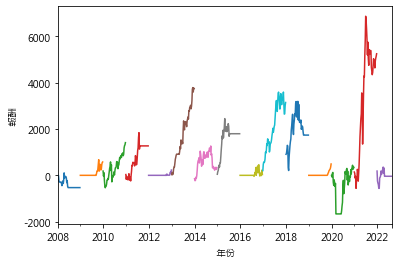

In [24]:
yl = ['2008','2009','2010','2011','2012','2013','2014','2015','2016','2017','2018','2019','2020','2021','2022']
for h in yl :
    trrtms = trrmsharpe.groupby(pd.Grouper(freq='1W')).sum().sum(axis=1)[str(h)].cumsum()
    trrtmsfig = (trrtms*6).plot()
trrtmsfig = plt.gcf()

plt.xlabel("年份")
plt.ylabel("報酬")
trrtmsfig.savefig('M夏普歷年損益.png')

# 量能突破策略

100%|██████████| 1100/1100 [05:39<00:00,  3.24it/s]


Text(0, 0.5, 'Profit')

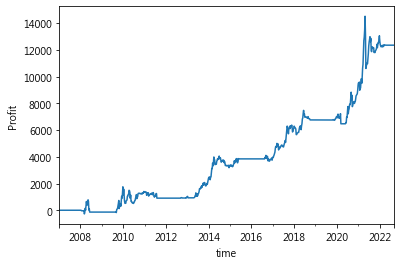

In [25]:
import talib
ERROR = []
trrv = pd.DataFrame()
pvz = pd.DataFrame()

for x in tqdm(SKTCRI):
    
    DDW[str(x)]['SMAX52'] = DDW[str(x)]["還原收盤價"].rolling(4).max()
    DDW[str(x)]["SMAX52S"] = DDW[str(x)]["MAX52"].shift(1)
    DDW[str(x)]["4MA"] = talib.MA(DDW[str(x)]["還原收盤價"].dropna(), timeperiod=5, matype=0)
    DDW[str(x)]["4MAS"] = DDW[str(x)]["4MA"].shift(1)
    DDW[str(x)]["DR"] = ((DDW[str(x)]["還原收盤價"] - DDW[str(x)]["還原收盤價"].shift(1))/DDW[str(x)]["還原收盤價"].shift(1))*100
    VBS = 0
    VBUY =[]
    for z in range(len(DDW[str(x)])):

        if DDW[str(x)]["成交金額(千)"].iloc[z]  > (DDW[str(x)]["成交金額(千)"].shift(1)*1.5).iloc[z] and DDW[str(x)]["成交金額(千)"].iloc[z] > 100000 \
        and DDW[str(x)]["收盤價"].iloc[z]  > (DDW[str(x)]["最高價"].shift(2)*1.1).iloc[z] and DDW[str(x)]['收盤價'].iloc[z] > DDW[str(x)]["SMAX52S"].iloc[z] \
        and DDW[str(x)]['大盤夏普'].iloc[z] > 0.3:
        
            VBS = 1

        elif  DDW[str(x)]["收盤價"].iloc[z] < DDW[str(x)]["最低價"].shift(2).iloc[z] or DDW[str(x)]['大盤夏普'].iloc[z]  < 0.3 :
            VBS = 0
            #buy.append("0")
        VBUY.append(VBS)
    DDW[str(x)]["VBUY"] = VBUY
    DDW[str(x)]["VBUYS"] = DDW[str(x)]["VBUY"].shift(1)
    pzb = DDW[str(x)]["VBUYS"]  
    pzb.name = str(x)
    pvzbs = DDW[str(x)]["VBUY"]
    pvzbs.name = str(x)
    DDW[str(x)]["RR"] = DDW[str(x)]["DR"] * DDW[str(x)]["VBUYS"].dropna().astype(int)
    PVT = DDW[str(x)]["RR"]
    PVT.name = str(x)
    if len(trr) == 0:
        trrv = PVT
    else:
        trrv = pd.merge(trrv,PVT,left_on = trrv.index,right_on = PVT.index,how = 'outer')
        trrv.set_index('key_0',inplace = True)
    if len(pz) == 0:
        pvz = pvzbs
    else:
        pvz = pd.merge(pvz,pvzbs,left_on = pvz.index,right_on = pvzbs.index,how = 'outer')
        pvz.set_index('key_0',inplace = True)

trrv1 =trrv.sort_index().sum(axis = 1).cumsum().plot()

plt.xlabel("time")
plt.ylabel("Profit")

# 整理量能買賣訊01值

34.51711491442543
0.0
264.0


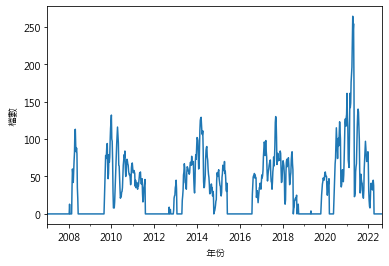

In [26]:
pvz1 = pvz.sort_index()
f4 = lambda x :float(x)
pvz2 = pvz1.applymap(f4)
pvz3 = pvz2.sum(axis=1)
pvz4 = pvz3.groupby(pd.Grouper(freq='1W')).tail(1)
print(pvz4.mean())
print(pvz4.min())
print(pvz4.max())
pvz4.plot()
plt.xlabel("年份")
plt.ylabel("檔數")
plt.savefig('量能部位變化表.png')

# <font color="red">量能當週買進部位</font>

In [27]:
#當週日期 = '2022-08-26'
#前週日期 = '2022-08-19'

量能持有部位 = pvz2.loc[當週日期][pvz2.loc[當週日期] ==1]
量能買進 = pvz2.loc[當週日期][(pvz2.loc[當週日期] ==1) & (pvz2.loc[前週日期] ==0)]
量能賣出 = pvz2.loc[當週日期][(pvz2.loc[當週日期] ==0) & (pvz2.loc[前週日期] ==1)]
print("量能買進標的")
print(量能買進)
print("量能買進檔數" , len(量能買進))
print("量能持有部位數目" , len(量能持有部位))
print("量能賣出部位")
print(量能賣出)
print("量能賣出檔數" , len(量能賣出))

量能買進標的
Series([], Name: 2022-08-26 00:00:00, dtype: float64)
量能買進檔數 0
量能持有部位數目 0
量能賣出部位
Series([], Name: 2022-08-26 00:00:00, dtype: float64)
量能賣出檔數 0


# 低接策略

100%|██████████| 1100/1100 [06:06<00:00,  3.00it/s]


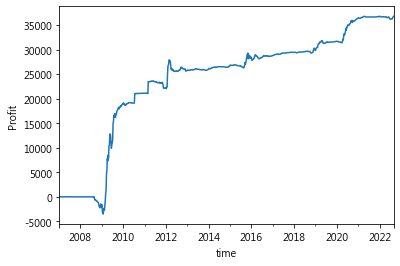

In [28]:
import talib
ERROR = []
trrkd = pd.DataFrame()
pzkd1 = pd.DataFrame()

for x in tqdm(SKTCRI):
    DDW[str(x)]["K"],DDW[str(x)]["D"] = talib.STOCH(DDW[str(x)]['最高價'], 
                              DDW[str(x)]['最低價'], 
                              DDW[str(x)]['收盤價'], 
                              fastk_period=52,
                              slowk_period=10,
                              slowk_matype=1,
                              slowd_period=10,
                              slowd_matype=1)
    DDW[str(x)]["4MA"] = talib.MA(DDW[str(x)]["還原收盤價"].dropna(), timeperiod=5, matype=0)
    DDW[str(x)]["4MAS"] = DDW[str(x)]["4MA"].shift(1)
    DDW[str(x)]["DR"] = ((DDW[str(x)]["還原收盤價"] - DDW[str(x)]["還原收盤價"].shift(1))/DDW[str(x)]["還原收盤價"].shift(1))*100
    DDW[str(x)]['大盤夏普']= DDW['TWA00']['sharpe'].fillna(method = 'pad',axis =0)
    KDBS = 0
    KDBUY =[]
    for z in range(len(DDW[str(x)])):

        if DDW[str(x)]["K"].iloc[z] > DDW[str(x)]["D"].iloc[z] and DDW[str(x)]["K"].shift(1).iloc[z] < DDW[str(x)]["D"].shift(1).iloc[z] \
        and DDW[str(x)]['成交金額(千)'].iloc[z] < 500000  \
        and DDW[str(x)]['D'].iloc[z] < 20 and DDW[str(x)]['還原收盤價'].iloc[z] < (DDW[str(x)]['MAX52S']*0.7).iloc[z] :
        
            KDBS = 1

        elif  DDW[str(x)]['收盤價'].iloc[z] < DDW[str(x)]['最低價'].rolling(4).min().shift(1).iloc[z] :
            KDBS = 0
            #buy.append("0")
        KDBUY.append(KDBS)
    DDW[str(x)]["KDBUY"] = KDBUY
    DDW[str(x)]["KDBUYS"] = DDW[str(x)]["KDBUY"].shift(1)
    pzkd = DDW[str(x)]["KDBUYS"]  
    pzkd.name = str(x)
    pzkds = DDW[str(x)]["KDBUY"]
    pzkds.name = str(x)
    DDW[str(x)]["KDRR"] = DDW[str(x)]["DR"] * DDW[str(x)]["KDBUYS"].dropna().astype(int)
    PVKD= DDW[str(x)]["KDRR"]
    PVKD.name = str(x)
    if len(trrkd) == 0:
        trrkd = PVKD
    else:
        trrkd = pd.merge(trrkd,PVKD,left_on = trrkd.index,right_on = PVKD.index,how = 'outer')
        trrkd.set_index('key_0',inplace = True)
    if len(pzkd) == 0:
        pzkd1 = pzkds
    else:
        pzkd1 = pd.merge(pzkd1,pzkds,left_on = pzkd1.index,right_on = pzkds.index,how = 'outer')
        pzkd1.set_index('key_0',inplace = True)

trrkd1 =trrkd.sort_index().sum(axis = 1).cumsum().plot()

plt.xlabel("time")
plt.ylabel("Profit")
plt.savefig('低接損益')

# 整理低接買賣訊01值

47.011002444987774
0.0
343.0


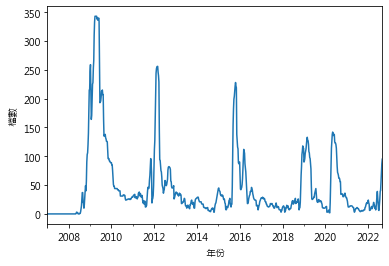

In [29]:
KD1 = pzkd1.sort_index()
f6 = lambda x :float(x)
KD2 = KD1.applymap(f6)
KD3 = KD2.sum(axis=1)
KD部位 =KD3.groupby(pd.Grouper(freq='1W')).tail(1)
print(KD部位.mean())
print(KD部位.min())
print(KD部位.max())
KD部位.plot()
plt.xlabel("年份")
plt.ylabel("檔數")
plt.savefig('低接部位變化表.png')

# 低接當週買進部位

In [30]:

低接持有部位 = KD2.loc[當週日期][KD2.loc[當週日期] ==1]
低接買進 = KD2.loc[當週日期][(KD2.loc[當週日期] ==1) & (KD2.loc[前週日期] ==0)]
低接賣出 = KD2.loc[當週日期][(KD2.loc[當週日期] ==0) & (KD2.loc[前週日期] ==1)]
print("低接買進標的")
print(低接買進)
print("低接買進檔數" , len(低接買進))
print("低接持有部位數目" , len(低接持有部位))
print("低接賣出部位")
print(低接賣出)
print("低接賣出檔數" , len(低接賣出))

低接買進標的
1304    1.0
1802    1.0
1909    1.0
2029    1.0
2489    1.0
3049    1.0
3260    1.0
3294    1.0
3306    1.0
3483    1.0
4564    1.0
5439    1.0
6229    1.0
6504    1.0
6523    1.0
6698    1.0
8477    1.0
Name: 2022-08-26 00:00:00, dtype: float64
低接買進檔數 17
低接持有部位數目 87
低接賣出部位
3078    0.0
6582    0.0
Name: 2022-08-26 00:00:00, dtype: float64
低接賣出檔數 2


# 融資爆發策略


100%|██████████| 1100/1100 [06:31<00:00,  2.81it/s]


Text(0, 0.5, 'Profit')

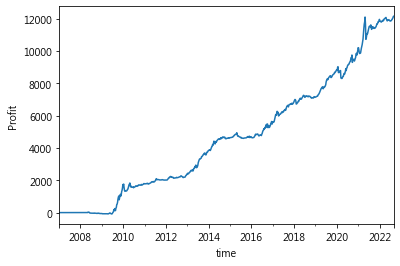

In [32]:
import talib
ERROR = []
trrmm = pd.DataFrame()
pzmm = pd.DataFrame()
pzmm1 = pd.DataFrame()
for x in tqdm(SKTCRI):
    
    
    DDW[str(x)]["4MA"] = talib.MA(DDW[str(x)]["還原收盤價"].dropna(), timeperiod=5, matype=0)
    DDW[str(x)]["4MAS"] = DDW[str(x)]["4MA"].shift(1)
    DDW[str(x)]["DR"] = ((DDW[str(x)]["還原收盤價"] - DDW[str(x)]["還原收盤價"].shift(1))/DDW[str(x)]["還原收盤價"].shift(1))*100
    DDW[str(x)]['大盤夏普']= DDW['TWA00']['sharpe'].fillna(method = 'pad',axis =0)
    MMBS = 0
    MMBUY =[]
    for z in range(len(DDW[str(x)])):

        if DDW[str(x)]['融資維持率(%)'].iloc[z] > 170 and DDW[str(x)]['融資維持率(%)'].shift(1).iloc[z] < 170  \
        and  DDW[str(x)]['成交金額(千)'].iloc[z] < 150000 and DDW[str(x)]['K'].iloc[z] > 50 and DDW[str(x)]['資使用率'].iloc[z] < 15 and  DDW[str(x)]['成交金額(千)'].iloc[z] > 10000 :
        
            MMBS = 1

        elif  DDW[str(x)]['收盤價'].iloc[z] < DDW[str(x)]['最低價'].rolling(4).min().shift(1).iloc[z] or  DDW[str(x)]['融資維持率(%)'].shift(1).iloc[z] < 160 :
            MMBS = 0
            #buy.append("0")
        MMBUY.append(MMBS)
    DDW[str(x)]["MMBUY"] = MMBUY
    DDW[str(x)]["MMBUYS"] = DDW[str(x)]["MMBUY"].shift(1)
    pzmm = DDW[str(x)]["MMBUYS"]  
    pzmm.name = str(x)
    pzmms = DDW[str(x)]["MMBUY"]
    pzmms.name = str(x)
    DDW[str(x)]["MMRR"] = DDW[str(x)]["DR"] * DDW[str(x)]["MMBUYS"].dropna().astype(int)
    PVMM= DDW[str(x)]["MMRR"]
    PVMM.name = str(x)
    if len(trrmm) == 0:
        trrmm = PVMM
    else:
        trrmm = pd.merge(trrmm,PVMM,left_on = trrmm.index,right_on = PVMM.index,how = 'outer')
        trrmm.set_index('key_0',inplace = True)
    if len(pzmm) == 0:
        pzmm1 = pzmms
    else:
        pzmm1 = pd.merge(pzmm1,pzmms,left_on = pzmm1.index,right_on = pzmms.index,how = 'outer')
        pzmm1.set_index('key_0',inplace = True)

trrmm1 =trrmm.sort_index().sum(axis = 1).cumsum().plot()

plt.xlabel("time")
plt.ylabel("Profit")


# 整理融資爆發買賣訊01值

28.30073349633252
0.0
132.0


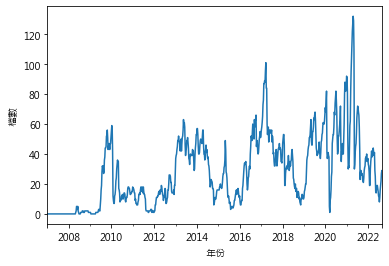

In [34]:
MM1 = pzmm1.sort_index()
f12 = lambda x :float(x)
MM2 = MM1.applymap(f12)
MM3 = MM2.sum(axis=1)
MM部位 =MM3.groupby(pd.Grouper(freq='1W')).tail(1)
print(MM部位.mean())
print(MM部位.min())
print(MM部位.max())
MM部位.plot()
plt.xlabel("年份")
plt.ylabel("檔數")
plt.savefig('量能部位變化表.png')

# 融資爆發當週買進部位

In [35]:
MM持有部位 = MM2.loc['2022-08-26'][(MM2.loc['2022-08-26']==1)]
MM買進 = MM2.loc['2022-08-26'][(MM2.loc['2022-08-26']==1) & (MM2.loc['2022-08-19']==0)]
MM賣出 = MM2.loc['2022-08-26'][(MM2.loc['2022-08-26']==0) & (MM2.loc['2022-08-19']==1)]
print("MM買進標的")
print(MM買進)
print("MM買進檔數" , len(MM買進))
print("MM持有部位數目" , len(MM持有部位))
print("MM賣出部位")
print(MM賣出)
print("MM賣出檔數" , len(MM賣出))

MM買進標的
1342    1.0
2362    1.0
Name: 2022-08-26 00:00:00, dtype: float64
MM買進檔數 2
MM持有部位數目 29
MM賣出部位
Series([], Name: 2022-08-26 00:00:00, dtype: float64)
MM賣出檔數 0


# 以下製圖研究不用

# 多空損益對比

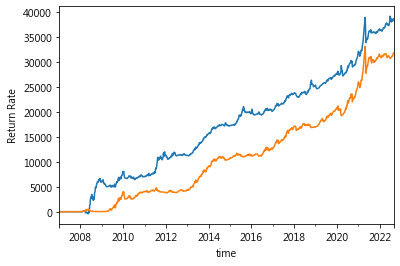

In [1164]:
trrsum = pd.concat([trr.sort_index().sum(axis=1),trrs.sort_index().sum(axis = 1)],axis=1)
trrsumf = trrsum.sum(axis = 1)
trrsumf.cumsum().plot()
trr.sort_index().sum(axis = 1).cumsum().plot()
plt.gcf()
plt.xlabel("time")
plt.ylabel("Return Rate")
plt.savefig('損益對比.png')

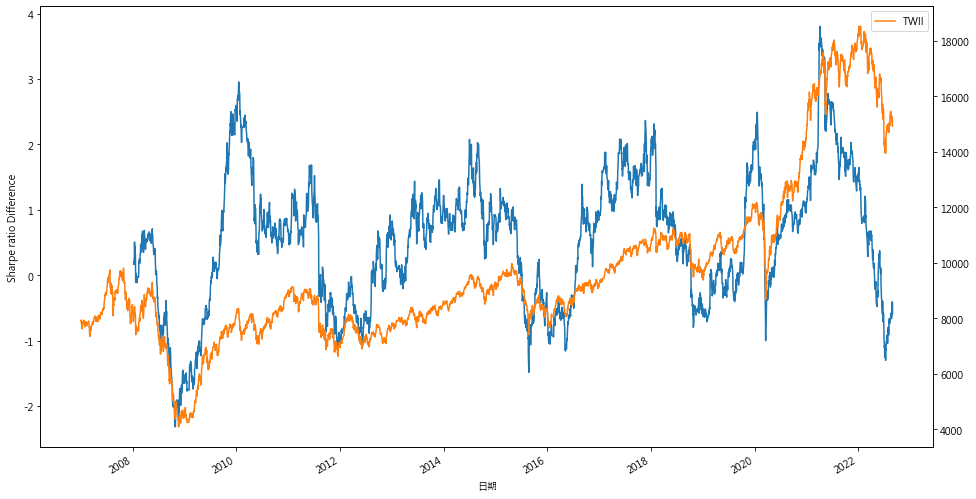

In [1166]:
plt.figure(figsize=(16,9))
plt.xlabel("time")
plt.ylabel("Sharpe ratio Difference")

plt.plot(shar2, label = "Sharpe ratio")
data_dict["TWA00"]["還原收盤價"].plot(secondary_y =True, label = "TWII")
plt.legend()
plt.savefig('大盤與夏普')

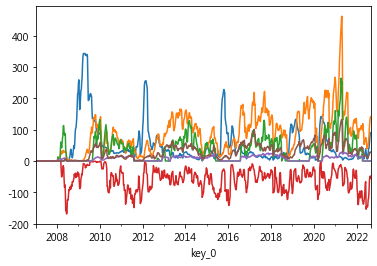

In [1261]:
KD部位.plot()
pz4.plot()
pvz4.plot()
pzs4.plot()
夏普部位.plot()
MM部位.plot()
plt.savefig('KD檔數')


<AxesSubplot:xlabel='key_0'>

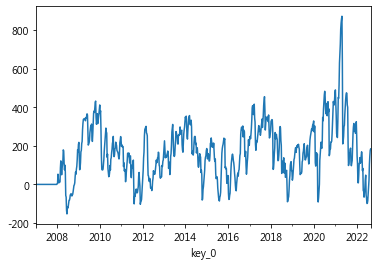

In [1263]:
總部位變化 = KD部位 + pz4 +pvz4 + (夏普部位*6) + pzs4
總部位變化.plot()

<AxesSubplot:xlabel='key_0'>

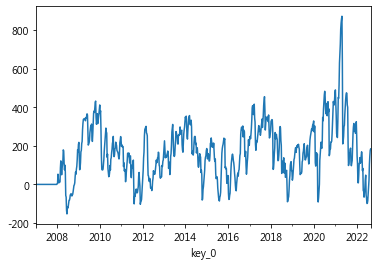

In [1265]:
總部位變化 = KD部位 + pz4 +pvz4 + (夏普部位*6) + pzs4
總部位變化.plot()

<AxesSubplot:xlabel='日期'>

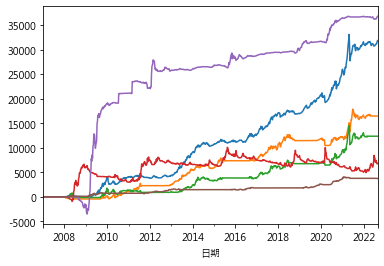

In [31]:
trr.sort_index().sum(axis = 1).cumsum().plot()
(tqt1*5).plot()
trrv.sort_index().sum(axis = 1).cumsum().plot()
trrsp.plot()
trrkd.sort_index().sum(axis = 1).cumsum().plot()
(trr2330*20).cumsum().plot()

In [ ]:
所有策略加總 = (tqt1*6) + trrsp + (trrv.sort_index().sum(axis = 1).cumsum()) +(trr2330*20) + (trr.sort_index().sum(axis = 1).cumsum()) + (trrkd.sort_index().sum(axis = 1).cumsum())
所有策略加總.plot()